,Time (s),Extensometer (mm),Load (kN),Engineering strain (abs.),Engineering stress (MPa)
0,0.0000,0.000000e+00,0.364120,0.000000e+00,15.171654
1,0.0200,-4.717588e-07,0.364118,-3.145059e-08,15.171579
2,0.0400,-9.435175e-07,0.364116,-6.290117e-08,15.171508
3,0.0600,-1.415276e-06,0.364114,-9.435173e-08,15.171433
4,0.0800,-1.887035e-06,0.364113,-1.258023e-07,15.171363
...,...,...,...,...,...
1954,39.0800,2.212456e-01,7.747406,1.474971e-02,322.808583
1955,39.1000,2.212485e-01,7.747242,1.474990e-02,322.801750
1956,39.1200,2.212513e-01,7.747077,1.475009e-02,322.794875
1957,39.1400,2.212542e-01,7.746913,1.475028e-02,322.788042


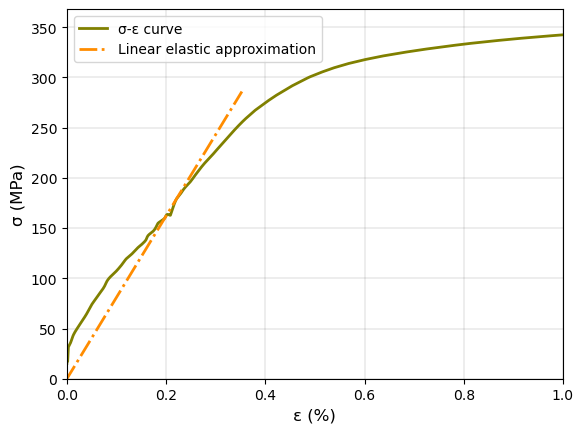

--> The R² value of the linear regression computed analytically is: ～ 0.9111
--> The R² value of the linear regression computed with r2_score is: ～ 0.9111
--> The regression reliability is: ADMISSIBLE
--> The elastic modulus in the linear elastic region is: ～ 81 GPa


In [4]:
#---------------------------------------------|| PHYTON CLASSES AND LIBRARIES ||---------------------------------------------#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorama, statistics
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from colorama import Fore, Style, Back
from statistics import mean 
from scipy import stats

#-------------------------------------------------|| DECLARED FUNCTIONS ||--------------------------------------------------#

'''
This function computes the engineering stress [MPa] once given the applied load [kN]. 
The nominal area is user-entered to be A0 = 24 [mm2]. 
'''
def engineering_stress(load):
    A0 = 24  
    return load*1000/A0

'''
This function computes the engineering strain [abs.] once given the applied extension [mm]. 
The gauge or unstrained length of the specimen is user-entered to be L0 = 15 [mm]. 
'''
def engineering_strain(extension): 
    L0 = 15 
    return extension/L0

'''
This function returns a float that is the average value of a given array of float values. The sum of all the values 
contained in the array is set to be null at the beginning, and is incremented by the element of the array in position [i].
A for cycle scans all the elements' positions. 

**** N.B. **** The Phyton class "mean" from the "statistics" library can automatically compute the average value of an array. 
For instance:  average_value = mean(name of the array).
'''
def median_value(array):
    sum_val = 0
    for i in range (0, array.shape[0]):
        sum_val += array[i]
    return sum_val/array.shape[0]  

'''
This function returns a float that is the R2 value of a given linear regression. The function scans all the elements' 
positions and compute the two float numbers RSS (Residual Sum of Squares) and TSS (Total Sum of Squares). Finally, the R2 
value is returned as 1-RSS/TSS.

**** N.B. **** The function "r2_score" from the Phyton Scikit-learn library (sklearn) can automatically compute the r2 value 
of a linear regression. For instance:  r2_value = r2_score(valori_reali, valori_attesi).
'''
def r2regression(valori_reali, valori_attesi):
    RSS = float(0)
    TSS = float(0)
    media = median_value(valori_reali) 
    for i in range (0, valori_reali.shape[0]):
        RSS += (valori_reali[i] - valori_attesi[i])**2
        TSS += (valori_reali[i] - media)**2
    return round(float(1-RSS/TSS), 4)

'''
This function returns a string indicating the goodness of the linear regression. 0.90 is set as a threshold value; if greater
precision is requested in very precise analysis, the corresponding litiming value can be readily modified.
'''
def regression_reliability(r2):
    if(r2>=0.95):
        return 'VERY GOOD'
    elif(r2<0.95 and r2>=0.90):
        return 'ADMISSIBLE'
    else:
        return 'NOT GOOD'
#-------------------------------------------------|| EXCEL FILES IMPORT ||--------------------------------------------------#

''' 
The Pandas software library is employed to import the excel data and create the corresponding DataFrame (hereby called 'df').
Notice that each column is then renamed for the sake of comprensibility.
'''
df = pd.DataFrame(pd.read_excel(r'C:\Users\Federico\Desktop\PhD\EXAMS\PHYTON DRIVING LICENSE\PROJECT_EXAM\RTdegC(2,0).xlsx', sheet_name='8.3kN', usecols=[0,1,2,3]))
df = df.rename(columns={'time\n[s]':'Time (s)', 'crosshead\n[mm]':'Crosshead (mm)', 'extensometer\n[mm]':'Extensometer (mm)','load\n[kN]':'Load (kN)'})
# df.dtypes --> to check that the elements contained in the DataFrame df are effectively float numbers

''' 
The engineering stress and strain are computed based on the functions "engineering_strain" and "engineering_stress" 
previously declared. Notice that a list is passed to each function, which returns a list itself. Then, each list is added 
to the dataframe specifying a new column, which will be inserted to the right. See:   df['name_of_the_new_column_to_be_added']

**** N.B. **** The Phyton class "drop" from the "Pandas" library can automatically compute remove an entire column from
a selected DataFrame. For instance:  df.drop('name_of_the_column_to_be_deleted', inplace=True, axis=1).
'''
df['Engineering strain (abs.)'] =  engineering_strain( df['Extensometer (mm)'] )
df['Engineering stress (MPa)'] =  engineering_stress( df['Load (kN)'] )
del df["Crosshead (mm)"] # crosshead data are useless and can be removed from the DataFrame
df.style.set_properties(**{'text-align': 'center'}) #centering the text
display(df) 

#-----------------------------------------------|| LINEAR INTERPOLATION ||------------------------------------------------#

''' 
The engineering strain and stress lists from the DataFrame constitutes the X and Y components to be linearly interpolated.
The corresponding interpolation function (named "interpolation_function") is generated by means of the interp1d class, 
property of the the scipy library. 1959 interpolation points, spanning all the engineering strain values starting from 0, 
are collected  into a proper array (termed "interpolation_points"). Notice that the number of interpolation points depends
on the length of the engineering strain column (df['Engineering strain (%)'].shape[0]). The interpolated, y- value will be
then defined by computing the interpolation function along each interpolation point.
'''
X = df['Engineering strain (abs.)']
Y = df['Engineering stress (MPa)']
interpolation_function = interp1d(X, Y, kind = 'linear')
interpolation_points = np.linspace(0, df.iloc[-1]['Engineering strain (abs.)'], Y.shape[0])
interpolated_value = interpolation_function(interpolation_points)

#-----------------------------------------------|| LINEAR REGRESSION ||------------------------------------------------#

''' 
The engineering strain and stress lists are reshaped into two new, separate 2D-arrays. The slicing technique allows only the 
first 1100 elements to be considered. Then, the linear regression class from the SkiLearn library performs the linear regression 
procedure by fitting X and Y; the fitting intercept is set to 'False' toforce the passage through (0,0). The estimated y-value 
of the linear regression is evaluated by way of the .predict function, based on the trained model. The coefficient of the 
linear regression, representing the slope of the as-generated straight line, constitutes the incremental elastic modulus of 
the material.

**** N.B. **** Reshaping each column list of the DataFrame is essential to compute the linear regression, as specified by the
SkiLearn documentation. Each reshaping procedure generates a 2D-matrix ( .values.reshape(rows, columns) ) with 1 single column
and a number of rows given by the total number of rows of the corresponding DataFrame list (in this case, owing to the slicing 
procedure, only 1100).
'''
X1 = X[:1100].values.reshape(-1,1)
Y1 = Y[:1100].values.reshape(-1,1)
regressor = LinearRegression(fit_intercept = False).fit(X1, Y1)
# print(regressor.intercept_) --> to verify that the straight line effectively passes through the origin  
y_estimated = regressor.predict(X1)
incremental_modulus = int(regressor.coef_/1000)

#-----------------------------------------------|| PLOTS AND GRAPHICS ||------------------------------------------------#

''' 
STRESS VS. STRAIN CURVE
The interpolation points, spanning all the engineering strain values, are represented on the x-axis. Notice that each strain
value is multiplied by 100, to express the percent engineering strain [%]. The interpolated values [MPa] are plotted on the 
y-axis.
'''
plt.plot(interpolation_points*100, interpolated_value, linestyle='solid', linewidth=2, color = 'olive', label = '\u03C3-\u03B5 curve')

''' 
LINEAR REGRESSION
The linear elastic approximation is represented with a dashed line. The x-values are all the percent engineering strains, 
while the y-values are estimated based on the previous linear regression.
'''
plt.plot(X1*100, y_estimated, linestyle='-.', linewidth=2, color = 'darkorange', label = 'Linear elastic approximation')

''' 
GRAPHICS 
'''
plt.xlabel('\u03B5 (%)', fontsize = 12) 
plt.ylabel('\u03C3 (MPa)', fontsize = 12)
plt.grid(color='k', linewidth=0.1)
plt.xlim(0, 1)
plt.ylim(0,)
plt.legend()
plt.show()

''' 
NUMERICAL RESULTS 

**** N.B. **** The R2 value computed by means of the r2_score(...,...) function of the Scikit-learn library is exactly the
same as the one evaluated analytically by way of the r2regression(valori_reali, valori_attesi) function typed manually
at the beginning of the script.
'''
print(Style.BRIGHT + '--> The R\u00b2 value of the linear regression computed analytically is: \uFF5E', r2regression(Y1, y_estimated))
print(Style.RESET_ALL + Style.BRIGHT + '--> The', Back.CYAN + 'R\u00b2 value' + Style.RESET_ALL, Style.BRIGHT + 'of the linear regression computed with r2_score is: ' + Back.CYAN +'\uFF5E', round(r2_score(Y1, y_estimated), 4))
print(Style.RESET_ALL + Style.BRIGHT + '--> The regression reliability is:', regression_reliability(r2_score(Y1, y_estimated)))
print(Style.RESET_ALL + Style.BRIGHT + '--> The', Back.YELLOW + 'elastic modulus' + Style.RESET_ALL, Style.BRIGHT + 'in the linear elastic region is: ' + Back.YELLOW +'\uFF5E', incremental_modulus, 'GPa')
